In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 
from chocolates import chocolate_masking_weighted

#Pour background_flowers_simples: (1.0, 1.0, 0.0) avec thresh = 80

def segmentation(img, weights=(1.0, 1.0, 0.1)):
    # --- 1. Load and Resize Image ---
    img = cv2.resize(img, (1600,1067))

    # --- 2. Convert to Grayscale ---
    masked = chocolate_masking_weighted(img, 20, weights)
    
    value = cv2.cvtColor(masked, cv2.COLOR_BGR2HSV)[:, :, 1]
    #plt.imshow(value, cmap='gray')

    thresh = 80
    value_thresh = (value > thresh).astype(np.uint8) * 255
    #plt.imshow(value_thresh, cmap='gray')

    # # --- 6. Erode to Remove Small Noise ---
    # radius = 2
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    # eroded = cv2.erode(value_thresh, kernel, iterations=1)
    # plt.imshow(eroded)

    # --- 6. Morphological Closing to Fill Gaps ---
    radius = 3
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    closed = cv2.morphologyEx(value_thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    #plt.imshow(closed)

    # Closing
    # radius = 4
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    # closed = cv2.morphologyEx(eroded, cv2.MORPH_CLOSE, kernel, iterations=2)
    # plt.imshow(closed, cmap='gray')

    # --- 5. Dilate to Connect Broken Edges ---
    # radius = 2
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    # dilated = cv2.dilate(value_thresh, kernel, iterations=1)
    #plt.imshow(closed, cmap='gray')

    # --- 4. Canny Edge Detection ---
    edges = cv2.Canny(closed, 200, 250) #50, 150
    #plt.imshow(edges, cmap='gray')

    # --- 5. Dilate to Connect Broken Edges ---
    radius = 2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    dilated = cv2.dilate(edges, kernel, iterations=1)
    #plt.imshow(dilated, cmap='gray')

    # --- 6. Morphological Closing to Fill Gaps ---
    # radius = 2
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    # closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
    #plt.imshow(closed)

    # --- 7. Remove Small Objects by Area Filtering ---
    # Find all contours
    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


    #plot contours
    cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
    cv2.imshow("Contours", img)
    #plt.imshow(img)

    # --- 7. Replace small contour filtering with ellipse fitting ---
    mask = np.zeros_like(closed)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 200000:
            cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)

    # Separate objects
    kernel = np.ones((40, 40), np.uint8) #TODO à voir si on peut réduire la taille du kernel
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # --- 8. Apply Mask to Original Image ---
    segmented_objects = cv2.bitwise_and(img, img, mask=mask)

    return segmented_objects

def plot_choc(img):
    plt.figure()
    plt.imshow(img)
    plt.title("Chocolate")
    plt.axis('off')
    plt.show()

def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    plt.show()

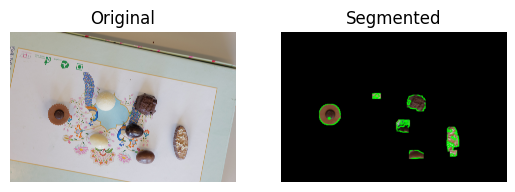

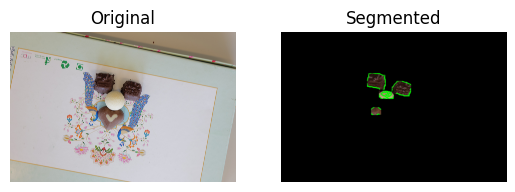

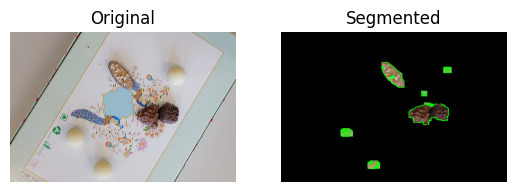

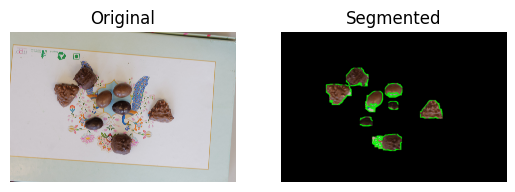

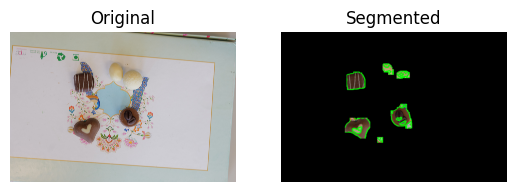

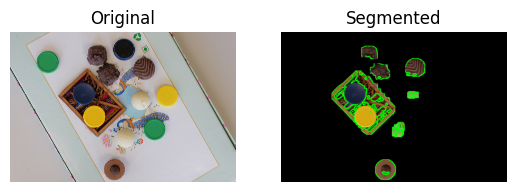

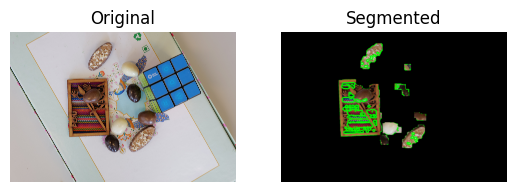

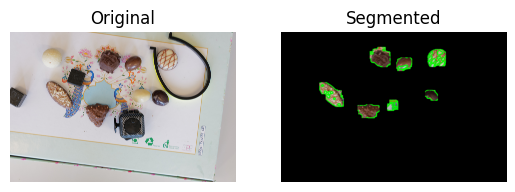

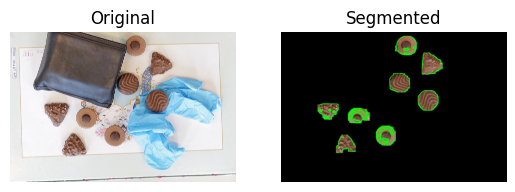

In [9]:
path_ref = 'dataset_project_iapr2025/background_flowers_simples/'
jpg_files = [f for f in os.listdir(path_ref)]
for i in range(len(jpg_files)):
    im_org = os.path.join(path_ref, jpg_files[i])
    img = mpimg.imread(im_org)
    res = segmentation(img)
    #plot_choc(res)
    show_comparison(img, res, "Segmented")

# for i in range(len(jpg_files)):
#     im_org = os.path.join(path_ref, jpg_files[i])
#     img = mpimg.imread(im_org)
#     res = segmentation(img)
#     #plot_choc(res)
#     show_comparison(img, res, "Segmented")